# PoseNet Tests

In [51]:
%load_ext autoreload
%autoreload 2

from IPython.display import HTML
from IPython.display import clear_output

import torch
from torch import nn
from torch.autograd import Variable
from datasets.apolloscape import Apolloscape
from utils.common import draw_poses
from utils.common import draw_record
from utils.common import imshow
import numpy as np
from torchvision import transforms, models
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import torch.optim as optim
from tqdm import tqdm
import os
import time
from datetime import datetime

from torchviz import make_dot

%matplotlib inline
plt.ion()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Dataset

In [59]:
APOLLO_PATH = "./data/apolloscape"

# Resize data before using
transform = transforms.Compose([
    transforms.Resize(260),
    transforms.CenterCrop(250),
    transforms.ToTensor()
])

# record_name = "Record029"
# apollo_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="road02_seg", transform=transform, record=record_name)

# record_name = "Record018" # Record018 - example with a turn
# apollo_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="road03_seg", transform=transform, record=record_name)

# record_name = "Record008"
# apollo_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="zpark-sample",
#                              transform=transform, record=record_name, normalize_poses=True,
#                              pose_format='quat')


train_record = None # 'Record001'
train_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="zpark-sample",
                             transform=transform, record=train_record, normalize_poses=True,
                             pose_format='quat', train=True, cache_transform=True)

val_record = None # 'Record011'
val_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="zpark-sample",
                             transform=transform, record=val_record, normalize_poses=True,
                             pose_format='quat', train=False, cache_transform=True)


print(train_dataset)
print(val_dataset)

train_dataloader = DataLoader(train_dataset, batch_size=75) # batch_size = 75
val_dataloader = DataLoader(val_dataset, batch_size=75) # batch_size = 75


we have original splits
cache_transform_dir = _cache_transform/zpark-sample/Resize_260_CenterCrop_250x250_ToTensor
we have original splits
cache_transform_dir = _cache_transform/zpark-sample/Resize_260_CenterCrop_250x250_ToTensor
Dataset: Apolloscape
    Road: zpark-sample
    Record: Record001
    Train: True
    Normalize Poses: True
    Length: 121 of 1121
    Cameras: ['Camera_2', 'Camera_1']
    Records: ['Record001', 'Record002', 'Record003', 'Record004', 'Record006', 'Record007', 'Record008', 'Record009', 'Record010', 'Record011', 'Record012', 'Record013', 'Record014']

Dataset: Apolloscape
    Road: zpark-sample
    Record: Record011
    Train: False
    Normalize Poses: True
    Length: 87 of 378
    Cameras: ['Camera_2', 'Camera_1']
    Records: ['Record001', 'Record002', 'Record003', 'Record004', 'Record006', 'Record007', 'Record008', 'Record009', 'Record010', 'Record011', 'Record012', 'Record013', 'Record014']



### Get Records Counts

In [61]:
# Show records with numbers of data points
recs_num = val_dataset.get_records_counts()
recs_num = sorted(recs_num.items(), key=lambda kv: kv[0], reverse=True)
print("Records Train:")
print("\n".join(["\t{} - {}".format(r[0], r[1]) for r in recs_num ]))


Records Train:
	Record014 - 50
	Record013 - 120
	Record012 - 121
	Record011 - 87
	Record010 - 0
	Record009 - 0
	Record008 - 0
	Record007 - 0
	Record006 - 0
	Record004 - 0
	Record003 - 0
	Record002 - 0
	Record001 - 0


### Checking Datasets

len(batch) = 2
len(batch[0]) = 2
len(batch[0][0]) = 8
batch_poses[0] =  tensor([ 1.3627, -0.7988, -0.3885,  0.0069, -0.0636,  0.7786, -0.6243])
unnormalized pose =  [ 6.18868994e+02 -2.45859599e+03  4.00620000e+01  6.90037524e-03
 -6.35855496e-02  7.78574765e-01 -6.24284029e-01]


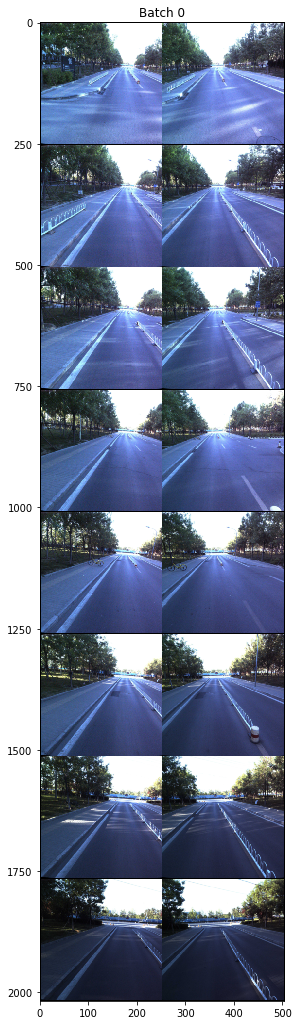

In [62]:
def collate_batch_images(batch_samples):
    just_images = [torch.cat(x, dim=2) for x in zip(*batch_samples[0])]
    return just_images


train_dataloader_iter = iter(train_dataloader)
train_batch = next(train_dataloader_iter)

print('len(batch) = {}'.format(len(train_batch)))
print('len(batch[0]) = {}'.format(len(train_batch[0])))
print('len(batch[0][0]) = {}'.format(len(train_batch[0][0])))

print('batch_poses[0] = ', train_batch[1][0][0])
pose = train_batch[1][0][0]
npose = np.zeros(7)
npose[:3] = pose.numpy()[:3] * train_dataset.poses_std[:3] + train_dataset.poses_mean[:3]
npose[3:] = pose.numpy()[3:]
pose = npose
print('unnormalized pose = ', pose)

images_col = collate_batch_images(train_batch)

img_out = vutils.make_grid(images_col, nrow=1)
imshow(img_out, title="Batch 0")

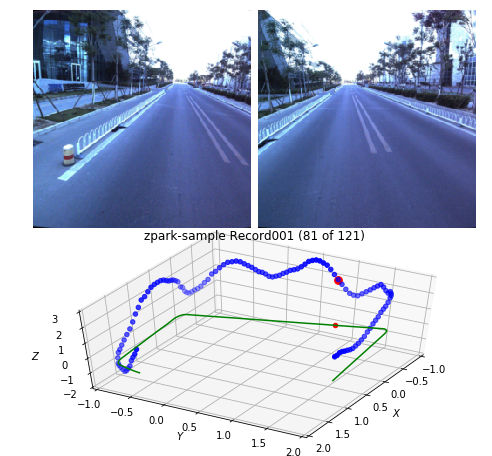

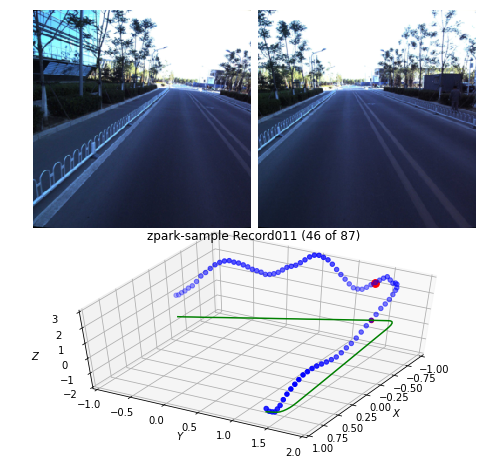

In [63]:
# Draw datasets
draw_record(train_dataset)
# plt.title('Train')
plt.show()

draw_record(val_dataset)
# plt.title('Val')
plt.show()



In [64]:
class PoseNet(torch.nn.Module):
    
    def __init__(self, feature_extractor, num_features=128):
        super(PoseNet, self).__init__()
        self.feature_extractor = feature_extractor
        self.feature_extractor.avgpool = torch.nn.AdaptiveAvgPool2d(1)
        fc_in_features = self.feature_extractor.fc.in_features
        self.feature_extractor.fc = torch.nn.Linear(fc_in_features, num_features)
        
        # Translation
        self.fc_xyz = torch.nn.Linear(num_features, 3)
        
        # Rotation in quaternions
        self.fc_quat = torch.nn.Linear(num_features, 4)
        
    def forward(self, x):
        # x is batch_images [2 x batch_size]
        
#         x = self.feature_extractor(x[0])

#         for xi in x:
#             print('type xi = {}'.format(type(xi)))
        
        x_features = [self.feature_extractor(xi) for xi in x]
        x_translations = [self.fc_xyz(xi) for xi in x_features]
        x_rotations = [self.fc_quat(xi) for xi in x_features]
        
        x_poses = [torch.cat((xt, xr), dim=1) for xt, xr in zip(x_translations, x_rotations)]
        
        return x_poses


# Create model
feature_extractor = models.resnet18(pretrained=True)
model = PoseNet(feature_extractor)

optimizer = optim.Adam(model.parameters(), lr=1e-5)

# feature_extractor = torch.nn.Sequential()
# feature_extractor.add_module('conv1', torch.nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4,
#                     stride=2, padding=1, bias=True))
# feature_extractor.add_module('relu1', torch.nn.LeakyReLU(0.2, inplace=False))
# feature_extractor.add_module('relu1', torch.nn.LeakyReLU(0.2, inplace=False))

# print(model)


In [79]:
# test_imgs1 = torch.rand(10, 3, 250, 250)
# test_imgs2 = torch.rand(10, 3, 250, 250)
batch_images = [torch.rand(1, 3, 250, 250) for _ in range(2)]
batch_poses = [torch.rand(1, 7) for _ in range(2)]

# for idx, m in enumerate(feature_extractor.modules()):
#     print("{} -> {}".format(idx, m))
# print('out.len = {}'.format(len(out)))
# print('out[0].len = {}'.format(len(out[0])))
# batch_poses

class PoseNetCriterion(nn.Module):
    def __init__(self):
        super(PoseNetCriterion, self).__init__()
        self.loss_fn = nn.L1Loss()
    
    def forward(self, x, y):
        """
        Args:
            x: list(N x 7, N x 7) - prediction (xyz, quat)
            y: list(N x 7, N x 7) - target (xyz, quat)
        """
#         print('x = {}'.format(x))
#         print('y = {}'.format(y))
        loss = 0
        for i in range(2):
#             print('part 1: {}; {}'.format(x[i][:, :3], y[i][:, :3]))
#             print('part 2: {}; {}'.format(x[i][:, 3:], y[i][:, 3:]))
            loss += self.loss_fn(x[i][:, :3], y[i][:, :3])
            loss += self.loss_fn(x[i][:, 3:], y[i][:, 3:])
        return loss
    

out = model(batch_images)
print('out = {}'.format(out))

criterion = PoseNetCriterion()
loss = criterion(out, batch_poses)
print('loss = {}'.format(loss))

optimizer.zero_grad()
loss.backward()
optimizer.step()


# batch_poses[0][:, :3, 3].size()




out = [tensor([[-0.4516, -0.1036,  0.4254,  0.1600, -0.2679,  0.2202, -0.0095]]), tensor([[-0.5146, -0.0913,  0.4092,  0.1474, -0.2830,  0.2044, -0.0539]])]
loss = 1.92348051071167


In [76]:
device = None
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('device = {}'.format(device))

device = cpu


In [77]:
class AverageMeter():
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        
    def update(self, value, n=1):
        self.val = value
        self.count += n
        self.sum += value * n
        self.avg = self.sum / self.count


# train function
def train(train_loader, model, criterion, optimizer, epoch, max_epoch):
    
    # switch model to training
    model.train()
    
    log_freq = 5
    
    losses = AverageMeter()
    
    end = time.time()
    for idx, (batch_images, batch_poses) in enumerate(train_loader):
#         if idx < len(train_loader) - 1: continue
        data_time = (time.time() - end)
        
        batch_images = [x.to(device) for x in batch_images]
        batch_poses = [x.to(device) for x in batch_poses]
        
        out = model(batch_images)
        loss = criterion(out, batch_poses)

        
        losses.update(loss, len(batch_images) * batch_images[0].size(0))
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_time = (time.time() - end)
        end = time.time()
        
        if log_freq != 0 and idx % log_freq == 0:
            print('Epoch: [{}/{}]\tBatch: [{}/{}]\t'
                  'Time: {batch_time:.3f}\t'
                  'Data Time: {data_time:.3f}\t'
                  'Loss: {losses.val:.3f}\t'
                  'Avg Loss: {losses.avg:.3f}\t'.format(
                   epoch + 1, max_epoch, idx + 1, len(train_loader),
                   batch_time=batch_time, data_time=data_time, losses=losses))
            
    print('Epoch: [{}/{}]\tTraining Loss: {:.3f}'.format(epoch+1, max_epoch, losses.avg))
    
    
def validate(val_loader, model, criterion, epoch):
    
    
    log_freq = 0 # len(val_loader)
    
    losses = AverageMeter()
    
    # set model to evaluation
    model.eval()
    
    with torch.no_grad():
        end = time.time()
        for idx, (batch_images, batch_poses) in enumerate(val_loader):
            data_time = time.time() - end
            batch_images = [x.to(device) for x in batch_images]
            batch_poses = [x.to(device) for x in batch_poses]
            
            # compute model output
            out = model(batch_images)
            loss = criterion(out, batch_poses)
            
            losses.update(loss, len(batch_images) * batch_images[0].size(0))
            
            batch_time = time.time() - end
            end = time.time()
            
            if log_freq != 0 and idx % log_freq == 0:
                print('Val Epoch: {}\t'
                      'Time: {batch_time:.3f}\t'
                      'Data Time: {data_time:.3f}\t'
                      'Loss: {losses.val:.3f}\t'
                      'Avg Loss: {losses.avg:.3f}'.format(
                       epoch + 1, batch_time=batch_time, data_time=data_time, losses=losses))
                
    print('Epoch: [{}]\tValidation Loss: {:.3f}'.format(epoch+1, losses.avg))
            
            
    
    

In [67]:
# Create model and optimizer
model = PoseNet(feature_extractor)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)


In [68]:
# Restore from checkpoint
checkpoint_file = '_checkpoints/20180727_221919_ttt_e143.pth.tar'

if 'checkpoint_file' in locals() and checkpoint_file is not None:
    if os.path.isfile(checkpoint_file):
        print('Loading from checkpoint: {}'.format(checkpoint_file))
        checkpoint = torch.load(checkpoint_file)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optim_state_dict'])
        start_epoch = checkpoint['epoch']
        

# if 'start_epoch' not in locals():
#     start_epoch = 0
# n_epochs = start_epoch + 1
# print('Epochs {} - {}'.format(start_epoch, n_epochs))


In [80]:

if 'start_epoch' not in locals():
    start_epoch = 0

n_epochs = start_epoch + 1
print('Training ...')
for e in range(start_epoch, n_epochs):
    
    train(train_dataloader, model, criterion, optimizer, e, n_epochs)
    
#     print('Validation ...')
    validate(val_dataloader, model, criterion, e)
    

Training ...
Epoch: [1/1]	Batch: [16/16]	Time: 5.286	Data Time: 4.065	Loss: 2.932	Avg Loss: 2.932	
Epoch: [1/1]	Training Loss: 2.932
Val Epoch: 1	Time: 2.771	Data Time: 0.303	Loss: 1.708	Avg Loss: 1.708
Val Epoch: 1	Time: 2.616	Data Time: 0.303	Loss: 1.758	Avg Loss: 1.733
Val Epoch: 1	Time: 2.537	Data Time: 0.246	Loss: 1.517	Avg Loss: 1.661
Val Epoch: 1	Time: 2.982	Data Time: 0.242	Loss: 1.829	Avg Loss: 1.703
Val Epoch: 1	Time: 2.747	Data Time: 0.257	Loss: 2.134	Avg Loss: 1.789
Val Epoch: 1	Time: 2.766	Data Time: 0.239	Loss: 1.989	Avg Loss: 1.823
Val Epoch: 1	Time: 2.962	Data Time: 0.392	Loss: 2.294	Avg Loss: 1.890
Val Epoch: 1	Time: 2.641	Data Time: 0.251	Loss: 2.435	Avg Loss: 1.958
Val Epoch: 1	Time: 2.433	Data Time: 0.234	Loss: 2.938	Avg Loss: 2.067
Val Epoch: 1	Time: 2.393	Data Time: 0.236	Loss: 3.353	Avg Loss: 2.196
Val Epoch: 1	Time: 2.514	Data Time: 0.212	Loss: 4.508	Avg Loss: 2.382
Epoch: [1]	Validation Loss: 2.382


In [ ]:
# for p in feature_extractor.parameters():
#     print(p.size())

# Test function for visiting backward graph
visited = set()
def visit_all(var, indent=''):
    if hasattr(var, 'data'):
        print("{}Data: {}".format(indent, var.data.size()))
    if hasattr(var, 'grad'):
        print("{}Grad Data: {}".format(indent, var.grad))
    if torch.is_tensor(var):
        print("{}Tensor {}".format(indent, var.size()))
    else:
        print("{}Type: {}".format(indent, type(var)))

    if hasattr(var, 'variable'):
        print("{}Variable: {}".format(indent, var.variable.size()))
        print("{}Data: {}".format(indent, var.variable))
        print("{}Data GRAD: {}".format(indent, var.variable.grad))
    if hasattr(var, 'saved_tensors'):
        print('{}Saved tensors: {}'.format(indent, var.saved_tensors))
    if hasattr(var, 'next_functions'):
        print('{}Next functions: {}'.format(indent, var.next_functions))
        for f in var.next_functions:
            if f[0] is not None:
                print("{}Function: {}".format(indent, f))
                visit_all(f[0], indent=indent+'  ')
    if hasattr(var, 'grad_fn'):
        print('{}Grad Fn: {}'.format(indent, var.grad_fn))
        visit_all(var.grad_fn, indent=indent+'  ')
    visited.add(var)
    
    
# visit_all(y)

# print(out.grad_fn.next_functions)

# out.__dir__()
# make_dot(out, params=dict(feature_extractor.named_parameters()))
make_dot(out[0])

In [ ]:
# Simple experiment to check backward graph state
a = torch.rand(1, requires_grad=True)
b = torch.rand(1, requires_grad=True)
c = torch.rand(1, requires_grad=True)
y = torch.log(a) * (b + torch.pow(c, 3))
print('a = {}'.format(a))
print('b = {}'.format(b))
print('c = {}'.format(c))
print('y = {}'.format(y))

# visit_all(y)
# print('--- BACKWARD ---')
# y.backward()
# visit_all(y)

make_dot(y)

In [10]:
# Save checkpoint
def save_checkpoint(model, optimizer, experiment_name='test', epoch=None):
    tstr = datetime.now().strftime('%Y%m%d_%H%M%S')
    fname = '{}_{}'.format(tstr, experiment_name)
    if epoch is not None:
        fname += '_e{:03d}'.format(epoch)
    fname += '.pth.tar'
    
    checkpoints_dir = '_checkpoints'
    if not os.path.exists(checkpoints_dir):
        os.makedirs(checkpoints_dir)
    
    fname_path = os.path.join(checkpoints_dir, fname)
#     print('fname_path = {}'.format(fname_path))
    
    checkpoint_dict = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optim_state_dict': optimizer.state_dict()
    }
    
    torch.save(checkpoint_dict, fname_path)
    
    print('Model saved to {}'.format(fname_path))
    

save_checkpoint(model, optimizer, 'ttt', n_epochs)
    

Model saved to _checkpoints/20180727_163351_ttt_e102.pth.tar
